## **Using Tensorflow for Time Series Prediction**

**Purpose:** "To try and predict the past". Using historical data, chop off a time you would like to predict, train the model on the non-chopped data, and have it predict the time period that was chopped off. The model will have no knowledge of the chopped-off data. The model's prediction is then compared to the known data that was chopped off.

**Author**: Ronan Lucey

**Author Email:** rml0018@uah.edu

**Date of Last Update:** January 9, 2018

###########################################################################################################################

The cell below checks the version of Python. Version 3.6.3 64 bit was used by the author.

In [ ]:
import sys
sys.version

The cell below imports the necessary libraries and packages for this analysis. Some of the Tensorflow packages may give warnings about future deprecation - this will be addressed when needed.

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
#tensorflow packages below may give warning about future deprecation 
#these will eventually need to be migrated to tensorflow estimator package
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn


The cell below checks the version of Tensorflow being used. Version 1.7.0 was used by the author.

In [ ]:
#check version of tensorflow
tf.__version__

In the next cell, the time series data to be used for the analysis is brought in. For this example, we will bring in Normalized Difference Vegetation Index (NDVI) data for one field in Nepal over a four year time period. 

This data is in CSV format, with values roughly once every two weeks. A pandas series will be created from this CSV file and the resulting pandas series is plotted to visualize the data. 

Additionally, the first ten points from the pandas series are printed so it can be confirmed that the data was correctly extracted from the CSV.

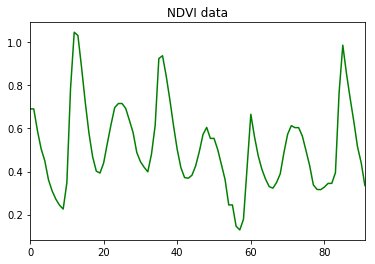

0    0.691
1    0.691
2    0.590
3    0.506
4    0.450
5    0.362
6    0.310
7    0.272
8    0.244
9    0.226
dtype: float64

In [3]:
#bring in the NDVI data from CSV
ndvi = np.genfromtxt('C:/Users/rlucey/Desktop/summer_18_work/ndvi_smooth_data.csv', delimiter=",")
#print out the NDVI data to view it if desired by uncommenting the line below
#print(ndvi)
#create a pandas time series from the NDVI
ts = pd.Series(ndvi)
#create a plot with the time series in green and display it
ts.plot(c='g', title = 'NDVI data')
plt.show()
#print first ten points of the pandas series
ts.head(10)


In the next cell, a new numpy array is created from the pandas series, and we created new variables to prepare for our analysis.

The number of study values in a period is defined. For this study, we define that there are 26 values in a study period. We are using one year as our study period, and because the NDVI values are bi-weekly, we have 52/2 = 26 values for each year.

The forecast horizon is also defined - how far into the future do we want to predict? For this study, we will predict one study period into the future.

*x_data* and *y_data* are then introduced. *x_data* is a numpy array of the NDVI values prior to the last study period. NDVI values from the last study period are removed. *y_data* is a numpy array of the NDVI values staggered one value after the *x_data* array.

For this example, *x_data* is TS[0:78], exactly three full years of bi-weekly data, while *y_data* is TS[1:79], three full years of bi-weekly data but staggered two weeks behind *x_data*. 

These two arrays are then reshaped to reflect the length of the study period, 26 for 26 bi-weekly values in a year. The shape of both the reshaped *x_data* and *y_data* is 3x26x1, because each dataset has 3 batches, 26 observations in each batch, and each observation is 1 value.

In [4]:
#create new variable that creates numpy array from pandas ndarray data
TS = np.array(ts)
#26 values in a study period, symbolizing one year
num_periods = 26
#we want to forecast one time period into the future
f_horizon = 1

#x data
#TS[0:(92-(92%26))] == TS[0:78]
#There is a remainder of 14 due to missing data values. These 14 values are cut off for x_data.
#x_data is a numpy array of all of the NDVI data prior to the final study period (the 14 cut off values)
x_data = TS[:(len(TS)-(len(TS)%num_periods))]
#the data is then reshaped. numpy.reshape() gives a new shape to an array without changing its data. 
x_batches = x_data.reshape(-1, 26, 1)
#the print statements below give clarity to how the reshaping works - turn them on to confirm
#print (len(x_batches)) #value is 3, because there are 3 full years of data in our dataset based on the num_periods value
#print (x_batches.shape) #the shape is 3x26x1. 3 batches, 26 observations in each batch, each observation is 1 value
#print (x_batches[0]) #print the first batch for confirmation that it contains 26 single observations as expected

#y data - staggered one value after the x data
#TS[1:(92-92%26)+1] == TS[1:79]
#y_data is a numpy array of NDVI data, staggered one forecast period behind the x_data
y_data = TS[1:(len(TS)-(len(TS)%num_periods))+f_horizon] 
#the data is also reshaped using numpy.reshape()
y_batches = y_data.reshape(-1, 26, 1)
#same as above, the print statements below give clarity to how the reshaping works. Should be same as x_batches.
#turn on print statements if you want to confirm this
#print (len(y_batches)) 
#print (y_batches.shape) 
#print (y_batches[0]) 


In the following cell, a function *test_data* is defined and then run. 

The function *test_data* takes three inputs - a time series of data, a forecast length, and the number of periods in the time series data. 
-  The function first finds the last period in the dataset plus the final value prior to the last period, and extracts these values to a new variable *test_x_setup*. 
-  *testX* and *testY* are then created from *test_x_setup* - *testX* having all but the last chronological value, and *testY* having all but the first chronological value.
    -  For this example, *testX* has the first 26 of the 27 cut out observations, and *testY* has the last 26 of the 27 cut out observations. 
-  *testX* and *testY* are then returned as outputs of the function.

The function is then run with variables we have already defined in prior cells - the time series *TS*, the forecast length *f_horizon*, and the number of periods *num_periods*. The results of this function can also be printed out if desired.

In [5]:
#pull out the test data using a newly defined function
def test_data(series,forecast,num_periods):
    test_x_setup = TS[-(num_periods+forecast):] # = TS[(-(26+1):] == characters from the 27th to last to the end
    testX = test_x_setup[:num_periods].reshape(-1,26,1) #taking the first 26 observations of the 27 and reshaping them
    testY = TS[-(num_periods):].reshape(-1,26,1) #taking the last 26 observations of the 27 and reshaping them
    return testX, testY #return the two reshaped datasets

#run the function with given time series, forecast length, # of periods
X_test, Y_test = test_data(TS, f_horizon, num_periods) 

#print statements to look at and clarify the results
#print (X_test.shape) #print the shape of X_test - 1x26x1. 1 batch, 26 observations in the batch, each observation is 1 value
#print (X_test) #print X_test to see what it looks like and the values (for this example, TS[67:92])
#print (Y_test) #print Y_test to see what it looks like and the values (for this example, TS[68:93])


In the following cell, the necessary components of the network are defined.

Variables are defined for the number of periods we are using to predict the next period, the number of input and output vectors to be included, and the number of hidden nodes to be included in the network. For more information on recursive neural networks and hidden nodes, see Drought forecasting using feed-forward recursive neural network, doi:10.1016/j.ecolmodel.2006.04.017

Emply placeholders for tensors are created called *x* and *y* - *x* for inputs and *y* for outputs. 

In [6]:
#reset any existing graphs
tf.reset_default_graph()

#define variables
#number of periods we are using to predict one period ahead
num_periods = 26
#number of input vectors
inputs = 1
#number of hidden nodes to be included in the network
hidden = 100
#number of output vectors
output = 1

#create empty variable objects
x = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])


In the following cell, the recursive neural network object is created, optimized to fit the needs of our study, and initiated.

A basic recursive neural network cell *basic_cell* is created using the Tensorflow package of the same name.  

A dynamic RNN is created using the RNNCell just specified and the input data, which is the placeholder tensor *x*.

A learning rate is then defined and stored in the variable *learning_rate*. This parameter scales the magnitude of weight updates to our RNN in order to minimize the RNN's loss function (more on this in the next cell). We use 0.001 for this study.

We then change the shape of *rnn_output*. Given *rnn_output*, tf.reshape() returns a tensor that has the same values as rnn_output with the newly defined shape. The special value -1 indicates that the size of that dimension is computed so that the total size remains constant. Hidden is the number of hidden nodes, which is defined in the previous cell. This output is named *stacked_rnn_output*.

We then use tf.layers.dense() to output a tensor the same shape as the *stacked_rnn_output* except the last dimension is of size units. This dimentionality is defined in this example as *output*, which in this example is 1.

Reshape is then used again to take the new dense tensorflow area and reshape it based on the number of periods and the number of output vectors specified. The third dimension [-1] is inferred so that the total size remains constant.


In [7]:
#create a recursive neural network object
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
#choose dynamic RNN
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, x, dtype=tf.float32)

#set a learning rate, and very small so minimum is not overshot
learning_rate = 0.001

#change the format into a tensorflow object
stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
#specify that it is a dense tensorflow layer
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
#reshape the results
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])


In the following cell, the cost function and gradient descend methods are defined, the gradient descent method optimizer variable is created, and a variable is created to initialize all variables.

The cost function is defined as the sum of elements across dimensions of a tensor, which in this case is the squares of the final tensor from the previous cell minus the placeholder y variable object. This is stored in the variable *loss*.

The gradient descent method aims to minimize loss function using its gradient values with respect to the parameters. In this example, we use the Adam Optimizer. The Adam Optimizer maintains exponential moving averages of gradient and its square. For more information see: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/. The gradient descent method is stored in the variable *optimizer*.

The Adam optimizer is then trained on the cost function, with the objective of minimizing the cost function. Lower numbers for the cost function indicate a better neural network with respect to its given training sample. The process of training the cost function is stored in the variable *training_op*.

Following the creation of these variables, a variable *init* is created that calls tf.global_variables_initializer(), which returns an op that initializes global variables. Tensorflow nodes are called ops (short for operations). An op takes zero or more Tensors, performs some computation, and produces zero or more Tensors. 

In [8]:
#define the cost function, which evaluates model quality 
#measure of "how good" a neural network did with respect to its given training sample and the expected output
loss = tf.reduce_sum(tf.square(outputs-y))
#gradient descent method (minimize loss function using its gradient values with respect to the parameters)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
#train the result of the application on the cost function 
training_op = optimizer.minimize(loss)

#variable to initialize all variables
init = tf.global_variables_initializer()


In the following cell, the number of epochs is defined, the neural network model created above is implemented on the training data, and predictions for the time period that was cut off the training data are printed.

First, the number of epochs, or iterations, is defined and stored in the variable *epochs*. 1000 epochs was selected for this example. For more information on picking an appropriate number of epochs for neural networks, see https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/.

The model is then implemented on the training dataset. *init* from the cell above is called to initialize all variables. Then for each epoch, sess.run() runs one "step" of TensorFlow computation at a time, by running the necessary graph fragment to execute every Operation and evaluate every Tensor in fetches, substituting the values in feed_dict for the corresponding input values. The fetches in this case is stored the *training_op* variable, which is the loss minimizer, while the corresponding input values are the original batches data (*x_batches* is TS[0:78], *y_batches* is TS[1:79]). 

There is then an if statement nested in the for loop that allows us to view the progress of the for loop. It prints out the Mean Square Error every 100th iteration of the loop. This allows us to monitor the progress of the loop, and whether the MSE is decreasing or not (which we are hoping it does). This print statement also allows us to see whether a larger or smaller number of epochs might be needed.  

Once the loop updating the weights has been completed, this optimized model is applied to the test data that was not exposed to the model during the training process. *X_test* is now fed to the model, with the output of this model run stored in the variable *x_pred*. These predictions for the cut-off time can then be printed out for observation. The next cell will compare these printed values to the dataset's original values.

In [9]:
#define the number of iterations
epochs = 1000

#implement the model created above on the training data
#create graph object
with tf.Session() as sess:
    #initialize data
    init.run()
    for ep in range(epochs):
        #adjust the weights applied to inputs
        sess.run(training_op, feed_dict={x: x_batches, y: y_batches})
        #print out every 100 iterations to see if accuracy is improving
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={x: x_batches, y: y_batches})
            print(ep, "\tMSE:", mse)
    
    #take parameters and apply them to test data
    x_pred = sess.run(outputs, feed_dict={x: X_test})
    #print out predictions for same range as test data
    print(x_pred)
    

0 	MSE: 18.4688
100 	MSE: 0.517172
200 	MSE: 0.109941
300 	MSE: 0.037645
400 	MSE: 0.0222054
500 	MSE: 0.0118305
600 	MSE: 0.00735795
700 	MSE: 0.00517409
800 	MSE: 0.00432096
900 	MSE: 0.00338639
[[[ 0.25538442]
  [ 0.14765465]
  [ 0.37988767]
  [ 0.43825525]
  [ 0.47893095]
  [ 0.61359662]
  [ 0.62976813]
  [ 0.56115454]
  [ 0.64074242]
  [ 0.58596683]
  [ 0.44615504]
  [ 0.39899349]
  [ 0.31121409]
  [ 0.24875769]
  [ 0.32669938]
  [ 0.38437533]
  [ 0.34637696]
  [ 0.38969827]
  [ 0.43771508]
  [ 0.7491591 ]
  [ 0.99408376]
  [ 0.7438404 ]
  [ 0.54971611]
  [ 0.53175938]
  [ 0.39257342]
  [ 0.32970378]]]


The following cell compares the original dataset's final year of values to the predicted values by the model over the same time frame.

The *X_test* (the original data values from the CSV) and the *x_pred* (the predicted data values by the model) are plotted against each other, and plot elements including title, legend, and axis labels are added.

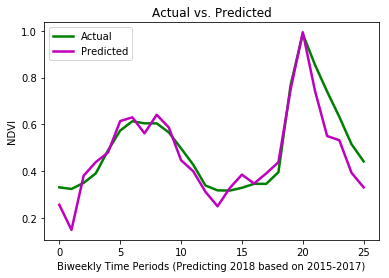

In [10]:
#plot to compare the test data to the predicted test data
#title for plot
plt.title("Actual vs. Predicted")
#plot the test data
plt.plot(pd.Series(np.ravel(X_test)), "g", markersize=5, lw=2.5, label='Actual')
#plot the predicted data
plt.plot(pd.Series(np.ravel(x_pred)), "m", markersize=5, lw=2.5, label='Predicted')
#add legend to plot
plt.legend()
#label X and Y axis
plt.xlabel("Biweekly Time Periods (Predicting 2018 based on 2015-2017)")
plt.ylabel("NDVI")
#display plot
plt.show()
